In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# get the data from
!wget https://www.dropbox.com/s/9czdg41ndl0lw07/BrainTumorData.zip?dl=0

In [ ]:
!unzip /content/BrainTumorData.zip?dl=0

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
ROOT_DIR= "/content/BrainTumorData/Brain Tumor Data Set"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR, dir)))
number_of_images.items()

dict_items([('Brain Tumor', 2513), ('Healthey', 2087)])

In [7]:
# Creating Training Folder


In [8]:
def dataFolder(p, split):

  if not os.path.exists("./"+p):
    os.mkdir("./"+p)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+p+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir)),
                                  size=(math.floor(split*number_of_images[dir])-5),
                                  replace=False ):
        O = os.path.join(ROOT_DIR,dir,img)
        D = os.path.join("./"+p,dir)
        shutil.copy(O,D)
        os.remove(O)
  else:
    print( f"{p}Folder exists")

In [9]:
dataFolder("train", 0.7)

In [10]:
  dataFolder("val", 0.15)

In [11]:
dataFolder("test", 0.15)

In [12]:
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR, dir)))
number_of_images.items()

dict_items([('Brain Tumor', 17), ('Healthey', 16)])

Model Build


In [13]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras

In [14]:
#CNN Model

model = Sequential()

model.add(Conv2D(filters= 16, kernel_size= (3,3), activation= 'relu', input_shape = (224,224,3)))


model.add(Conv2D(filters= 32, kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 64, kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
                
model.add(Conv2D(filters= 128, kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 128, kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 256, kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters= 256, kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))



model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation="sigmoid"))

model.summary()
                                  


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [15]:
model.compile(optimizer='adam', loss= keras.losses.binary_crossentropy, metrics=['accuracy'] )

Preparing data using data generator

In [16]:
def preprocessingImages(path):

  """
  input:Path
  output: Pre processed images

  """
  
  image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, rescale= 1/255, horizontal_flip= True)
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')
  
  return image

In [17]:
path = "/content/train"
train_data = preprocessingImages(path)

Found 3209 images belonging to 2 classes.


In [18]:
def preprocessingImages2(path):

  """
  input:Path
  output: Pre processed images

  """
  
  image_data = ImageDataGenerator(rescale= 1/255)
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')
  
  return image

In [19]:
path = "/content/test"
test_data = preprocessingImages2(path)

Found 679 images belonging to 2 classes.


In [20]:
path = "/content/val"
val_data = preprocessingImages2(path)

Found 679 images belonging to 2 classes.


In [21]:
# Early stopping and model check point
from keras.callbacks import ModelCheckpoint, EarlyStopping

#early stopping

es=EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=7, verbose=1, mode='auto')

#model check point
mc=ModelCheckpoint(monitor="val_accuracy", filepath="./bestmodel.h5", verbose=1, save_best_only=True, mode='auto')

cd=[es,mc]

Model Training


In [22]:
hs=model.fit_generator(generator=train_data, 
                       steps_per_epoch=16, 
                       epochs=60,
                       verbose=1,
                       validation_data=val_data, 
                       validation_steps=16 , 
                       callbacks=cd)


Epoch 1/60
16/16 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.5332
Epoch 1: val_accuracy improved from -inf to 0.55859, saving model to ./bestmodel.h5
16/16 [==============================] - 24s 708ms/step - loss: 0.6984 - accuracy: 0.5332 - val_loss: 0.6921 - val_accuracy: 0.5586
Epoch 2/60
16/16 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5440
Epoch 2: val_accuracy did not improve from 0.55859
16/16 [==============================] - 10s 624ms/step - loss: 0.6923 - accuracy: 0.5440 - val_loss: 0.6918 - val_accuracy: 0.5293
Epoch 3/60
16/16 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5195
Epoch 3: val_accuracy improved from 0.55859 to 0.56641, saving model to ./bestmodel.h5
16/16 [==============================] - 10s 625ms/step - loss: 0.6918 - accuracy: 0.5195 - val_loss: 0.6884 - val_accuracy: 0.5664
Epoch 4/60
16/16 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.5645
Epoch 

In [23]:
#Model Graphical Interpretation
h=hs.history
h.keys()



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

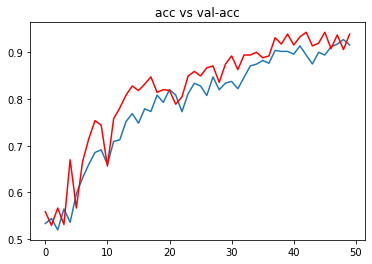

In [24]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c="red")

plt.title("acc vs val-acc")
plt.show()

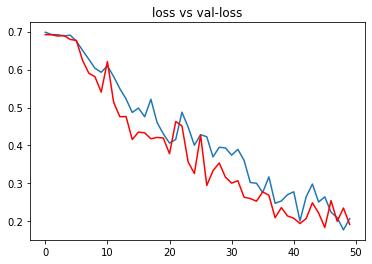

In [25]:
import matplotlib.pyplot as plt

plt.plot(h['loss'])
plt.plot(h['val_loss'], c="red")

plt.title("loss vs val-loss")
plt.show()

In [26]:
# Model Accuracy from keras.models import load_model
from keras.models import load_model

model=load_model("/content/bestmodel.h5")

In [33]:
acc= model.evaluate_generator(test_data)[1]

print(f"The Accuracy of our Model is {acc*100} %")

The Accuracy of our Model is 93.51988434791565 %


In [35]:
from keras.preprocessing.image import load_img, img_to_array

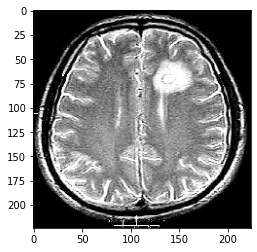

TUMOUR Detected in the MRI


In [38]:
path ="/content/BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1440).jpg"
img = load_img(path, target_size= (224,224))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr.shape

input_arr = np.expand_dims(input_arr, axis= 0 )


pred = model.predict(input_arr)[0][0]



if pred <= 0.5: 
  
  print("TUMOUR Detected in the MRI") 
else: 
  
  print("NO TUMOUR Detected in the MRI")
